# MODEL 3-B Version 2.3.2.5
### Contains only fixed-before-conditional trials without intervening BLs
### Combines A & C trials into single regressor
### Accounts for last three noisy volumes via FSL ROI -- removal and recreation of EPI files
### Compares positive derivative to negative derivatives

#  WMAZE Beta Series correlation Analysis

## Obtains Correlation values for the regions of interest:
### Hippocampus (FS labels: hippocampus [17, 53])
### Dorsal caudate (hand-drawn by Mandy)
### Medial PFC (FS labels: rostral anterior cingulate [1026, 2026] & caudal anterior cingulate [1002, 2002])
### Dorsolateral PFC (Lausanne atlas: dlPFC)

### Use Glob to grab all previously created anatomy masks and beta series cope files

In [45]:
from glob import glob
 
sids = ['WMAZE_001', 'WMAZE_002', 'WMAZE_004', 'WMAZE_005', 'WMAZE_006',
        'WMAZE_007', 'WMAZE_008', 'WMAZE_009', 'WMAZE_010', 'WMAZE_012',
        'WMAZE_017', 'WMAZE_018', 'WMAZE_019', 'WMAZE_020', 'WMAZE_021',  
        'WMAZE_022', 'WMAZE_023', 'WMAZE_024', 'WMAZE_026', 'WMAZE_027']
proj_dir = '/home/data/madlab/data/mri/wmaze'
 
mask_filenames = []
cope_files = []

for SID in sids:
    # Grab the mask files for each subject
    mask_filenames_glob = glob(proj_dir + '/roi_analysis/mask/anat_masks/_subject_id_' + SID + '/_anatmask_xfm*/*')
    mask_filenames.append(sorted(mask_filenames_glob))
    # Grab the cope files for each subject
    subjcopes_glob = glob(proj_dir + '/frstlvl/wmaze_MRthesis/fixed_before_conditional/model3_B/merge_copes/'
                          + SID + '/merged/cope_*')
    cope_files.append(sorted(subjcopes_glob))
    # If there are no cope files, print subject id
    if len(cope_files[-1]) == 0:
        print(SID)

### Cell to double-check the array indexing for both the masks and the copes

In [2]:
print '0. left dlPFC'
print(mask_filenames[0][0]) #lh-dlPFC Lausanne
print""
print '1. left hippocampus'
print(mask_filenames[0][1]) #lh-hippocampus
print""
print '2. left mPFC (rac-only)'
print(mask_filenames[0][2]) #lh-mPFC_rac-only
print""
print '3. left mPFC (orig)'
print(mask_filenames[0][3]) #lh-mPFC (orig)
print""
print '4. left putamen'
print(mask_filenames[0][4]) #lh-putamen
print""
print '5. left caudate'
print(mask_filenames[0][5]) #lh-caudate
print""
print '6. right dlPFC'
print(mask_filenames[0][6]) #rh-dlPFC Lausanne
print""
print '7. right hippocampus'
print(mask_filenames[0][7]) #rh-hippocampus
print""
print '8. right mPFC (orig)'
print(mask_filenames[0][8]) #rh-mPFC (orig)
print""
print '9. right putamen'
print(mask_filenames[0][9]) #rh-putamen
print""
print '10. right caudate'
print(mask_filenames[0][10]) #rh-caudate
print""
print '11. right mPFC (rac-only)'
print(mask_filenames[0][11]) #rh-mPFC_rac_only
print""
print '12. left mPFC (rac-cac)'
print(mask_filenames[0][12]) #lh-mPFC_rac-cac
print""
print '13. right mPFC (rac-cac)'
print(mask_filenames[0][13]) #rh-mPFC_rac-cac
print""

print '-----'

print 'cope_learning'
print(cope_files[0][0]) 
print ""
print 'cope_nonlearning'
print(cope_files[0][1]) 

#for i in cope_files:
#    print(len(i))


0. left dlPFC
/home/data/madlab/data/mri/wmaze/roi_analysis/mask/anat_masks/_subject_id_WMAZE_001/_anatmask_xfm0/lh-dlPFC_lausanne_warped.nii.gz

1. left hippocampus
/home/data/madlab/data/mri/wmaze/roi_analysis/mask/anat_masks/_subject_id_WMAZE_001/_anatmask_xfm0/lh-hippocampus_warped.nii.gz

2. left mPFC (rac-only)
/home/data/madlab/data/mri/wmaze/roi_analysis/mask/anat_masks/_subject_id_WMAZE_001/_anatmask_xfm0/lh-mPFC_rac-only_warped.nii.gz

3. left mPFC (orig)
/home/data/madlab/data/mri/wmaze/roi_analysis/mask/anat_masks/_subject_id_WMAZE_001/_anatmask_xfm0/lh-mPFC_warped.nii.gz

4. left putamen
/home/data/madlab/data/mri/wmaze/roi_analysis/mask/anat_masks/_subject_id_WMAZE_001/_anatmask_xfm0/lh-putamen_warped.nii.gz

5. left caudate
/home/data/madlab/data/mri/wmaze/roi_analysis/mask/anat_masks/_subject_id_WMAZE_001/_anatmask_xfm0/lh_caudate_anat_mask_warped.nii.gz

6. right dlPFC
/home/data/madlab/data/mri/wmaze/roi_analysis/mask/anat_masks/_subject_id_WMAZE_001/_anatmask_xfm0/rh

### Use binarized mask to obtain activation in left & right hemisphere for each ROI

In [46]:
import nibabel as nb
import pandas as pd
import numpy as np
from scipy import stats


#Dictionary containing multiple arrays referenced by keywords
all_data = {'subjid':[],
            'lh_hp_nonlearning':[], 'rh_hp_nonlearning':[], 
            'lh_hp_learning':[], 'rh_hp_learning':[],                 
            'lh_caudate_nonlearning':[], 'rh_caudate_nonlearning':[], 
            'lh_caudate_learning':[], 'rh_caudate_learning':[],  
            'lh_dlPFC_nonlearning':[], 'rh_dlPFC_nonlearning':[], 
            'lh_dlPFC_learning':[], 'rh_dlPFC_learning':[],            
            'lh_mPFC_nonlearning':[], 'rh_mPFC_nonlearning':[], 
            'lh_mPFC_learning':[], 'rh_mPFC_learning':[]}

corr_matrix = np.zeros((len(sids), 5))

# For each interation in the length of subject ids
for i in range(len(sids)):
    #Append the subject id
    all_data['subjid'].append(sids[i])
    #Load the left and right hippocampus mask files using Nibabel 
    lh_hp_img = nb.load(mask_filenames[i][1])
    rh_hp_img = nb.load(mask_filenames[i][7])
    
    lh_caudate_img = nb.load(mask_filenames[i][5])
    rh_caudate_img = nb.load(mask_filenames[i][10])
    
    lh_dlPFC_img = nb.load(mask_filenames[i][0])
    rh_dlPFC_img = nb.load(mask_filenames[i][6])
    
    lh_mPFC_img = nb.load(mask_filenames[i][12])
    rh_mPFC_img = nb.load(mask_filenames[i][13])
    
    
    #Load copes for learning vs nonlearning betas
    cope_learning_img = nb.load(cope_files[i][0])
    cope_nonlearning_img = nb.load(cope_files[i][1])
     
  
    ########################
    ### Left Hippocampus ###
    ########################
    
    # cope_nonlearning
    lh_hp_nonlearning_data = cope_nonlearning_img.get_data()[lh_hp_img.get_data() > 0.]
    all_data['lh_hp_nonlearning'].append(lh_hp_nonlearning_data[0:-1])
    
    # cope_learning
    lh_hp_learning_data = cope_learning_img.get_data()[lh_hp_img.get_data() > 0.]
    all_data['lh_hp_learning'].append(lh_hp_learning_data[0:-1])
    
    #########################
    ### Right Hippocampus ###
    #########################
    
    # cope_nonlearning
    rh_hp_nonlearning_data = cope_nonlearning_img.get_data()[rh_hp_img.get_data() > 0.]
    all_data['rh_hp_nonlearning'].append(rh_hp_nonlearning_data[0:-1])

    # cope_learning
    rh_hp_learning_data = cope_learning_img.get_data()[rh_hp_img.get_data() > 0.]
    all_data['rh_hp_learning'].append(rh_hp_learning_data[0:-1])
    
    #####################
    ### Left Caudate ###
    ##################### 
    
    # cope_nonlearning
    lh_caudate_nonlearning_data = cope_nonlearning_img.get_data()[lh_caudate_img.get_data() > 0.]
    all_data['lh_caudate_nonlearning'].append(lh_caudate_nonlearning_data[0:-1])

    # cope_learning
    lh_caudate_learning_data = cope_learning_img.get_data()[lh_caudate_img.get_data() > 0.]
    all_data['lh_caudate_learning'].append(lh_caudate_learning_data[0:-1])
    
    #####################
    ### Right Caudate ###
    ##################### 
    
    # cope_nonlearning
    rh_caudate_nonlearning_data = cope_nonlearning_img.get_data()[rh_caudate_img.get_data() > 0.]
    all_data['rh_caudate_nonlearning'].append(rh_caudate_nonlearning_data[0:-1])

    # cope_learning
    rh_caudate_learning_data = cope_learning_img.get_data()[rh_caudate_img.get_data() > 0.]
    all_data['rh_caudate_learning'].append(rh_caudate_learning_data[0:-1])  
    
    ####################
    #### Left mPFC #####
    ####################
    
    # cope_nonlearning
    lh_mPFC_nonlearning_data = cope_nonlearning_img.get_data()[lh_mPFC_img.get_data() > 0.]
    all_data['lh_mPFC_nonlearning'].append(lh_mPFC_nonlearning_data[0:-1])
    
    # cope_learning
    lh_mPFC_learning_data = cope_learning_img.get_data()[lh_mPFC_img.get_data() > 0.]
    all_data['lh_mPFC_learning'].append(lh_mPFC_learning_data[0:-1])    
    
    #####################
    #### Right mPFC #####
    #####################
    
    # cope_nonlearning
    rh_mPFC_nonlearning_data = cope_nonlearning_img.get_data()[rh_mPFC_img.get_data() > 0.]
    all_data['rh_mPFC_nonlearning'].append(rh_mPFC_nonlearning_data[0:-1])

    # cope_learning
    rh_mPFC_learning_data = cope_learning_img.get_data()[rh_mPFC_img.get_data() > 0.]
    all_data['rh_mPFC_learning'].append(rh_mPFC_learning_data[0:-1]) 
    
    ####################
    #### Left dlPFC ####
    ####################
    
    # cope_nonlearning
    lh_dlPFC_nonlearning_data = cope_nonlearning_img.get_data()[lh_dlPFC_img.get_data() > 0.]
    all_data['lh_dlPFC_nonlearning'].append(lh_dlPFC_nonlearning_data[0:-1])
    
    # cope_learning
    lh_dlPFC_learning_data = cope_learning_img.get_data()[lh_dlPFC_img.get_data() > 0.]
    all_data['lh_dlPFC_learning'].append(lh_dlPFC_learning_data[0:-1])  
    
    #####################
    ### Right dlPFC ###
    #####################
    
    # cope_nonlearning
    rh_dlPFC_nonlearning_data = cope_nonlearning_img.get_data()[rh_dlPFC_img.get_data() > 0.]
    all_data['rh_dlPFC_nonlearning'].append(rh_dlPFC_nonlearning_data[0:-1])

    # cope_learning
    rh_dlPFC_learning_data = cope_learning_img.get_data()[rh_dlPFC_img.get_data() > 0.]
    all_data['rh_dlPFC_learning'].append(rh_dlPFC_learning_data[0:-1])    
    
    #array with keys for each part of all_data dictionary
    all_keys = ['lh_hp_nonlearning', 'rh_hp_nonlearning', 
                'lh_hp_learning', 'rh_hp_learning',                 
                'lh_caudate_nonlearning', 'rh_caudate_nonlearning', 
                'lh_caudate_learning', 'rh_caudate_learning',  
                'lh_dlPFC_nonlearning', 'rh_dlPFC_nonlearning', 
                'lh_dlPFC_learning', 'rh_dlPFC_learning',            
                'lh_mPFC_nonlearning', 'rh_mPFC_nonlearning', 
                'lh_mPFC_learning', 'rh_mPFC_learning']
    
    for key in all_keys: 
        # averaging each column for only the current participant 
        all_data[key][-1] = np.mean(all_data[key][-1], axis = 0)
       
    #Combined Hippocampus average for nonlearning and learning
    all_data['hp_nonlearning'] = (np.array(all_data['lh_hp_nonlearning'][-1]) + 
                                  np.array(all_data['rh_hp_nonlearning'][-1]))/2.
    all_data['hp_learning'] = (np.array(all_data['lh_hp_learning'][-1]) + 
                               np.array(all_data['rh_hp_learning'][-1]))/2.
                             
    #Combined Caudate average for nonlearning and learning
    all_data['caudate_nonlearning'] = (np.array(all_data['lh_caudate_nonlearning'][-1]) + 
                                       np.array(all_data['rh_caudate_nonlearning'][-1]))/2.
    all_data['caudate_learning'] = (np.array(all_data['lh_caudate_learning'][-1]) + 
                                    np.array(all_data['rh_caudate_learning'][-1]))/2.

    # Combined mPFC average for nonlearning and learning
    all_data['mPFC_nonlearning'] = (np.array(all_data['lh_mPFC_nonlearning'][-1]) + 
                                    np.array(all_data['rh_mPFC_nonlearning'][-1]))/2.
    all_data['mPFC_learning'] = (np.array(all_data['lh_mPFC_learning'][-1]) + 
                                 np.array(all_data['rh_mPFC_learning'][-1]))/2.

    #Combined dlPFC average for nonlearning and learning
    all_data['dlPFC_nonlearning'] = (np.array(all_data['lh_dlPFC_nonlearning'][-1]) + 
                                     np.array(all_data['rh_dlPFC_nonlearning'][-1]))/2.
    all_data['dlPFC_learning'] = (np.array(all_data['lh_dlPFC_learning'][-1]) + 
                                  np.array(all_data['rh_dlPFC_learning'][-1]))/2.   
   
    
    # Creation of the correlation matrix (with subject id column)
    corr_matrix[i][0] = float(sids[i][-3:])
    corr_matrix[i][1] = stats.pearsonr(all_data['hp_learning'], all_data['mPFC_learning'])[0]
    corr_matrix[i][2] = stats.pearsonr(all_data['hp_nonlearning'], all_data['mPFC_nonlearning'])[0]
    corr_matrix[i][3] = stats.pearsonr(all_data['caudate_learning'], all_data['dlPFC_learning'])[0]
    corr_matrix[i][4] = stats.pearsonr(all_data['caudate_nonlearning'], all_data['dlPFC_nonlearning'])[0]

##  Non-normalized correlation matrix for beta series

In [47]:
import pandas as pd
#create Pandas dataframe to store correlations
correlation_chart = {}
correlation_chart['1_HPC-mPFC_learning'] = corr_matrix[:, 1] 
correlation_chart['2_HPC-mPFC_nonlearning'] = corr_matrix[:, 2] 
correlation_chart['3_Caudate-dlPFC_learning'] = corr_matrix[:, 3] 
correlation_chart['4_Caudate-dlPFC_nonlearning'] = corr_matrix[:, 4] 
correlation_chart_df = pd.DataFrame.from_dict(correlation_chart)

In [48]:
correlation_chart_df

,1_HPC-mPFC_learning,2_HPC-mPFC_nonlearning,3_Caudate-dlPFC_learning,4_Caudate-dlPFC_nonlearning
0,0.427762,0.533800,0.386641,0.385615
1,0.638085,0.760874,0.524824,0.744257
2,0.706879,0.493976,0.633300,0.562764
3,1.000000,0.674261,-1.000000,0.748048
4,0.651781,1.000000,0.325414,1.000000
5,0.745421,0.413857,0.492417,0.468608
6,0.820700,0.822945,0.787213,0.856577
7,0.800824,0.601540,0.199882,0.361100
8,0.496336,0.583512,0.595354,0.498252
9,0.690862,-0.175846,0.443858,-0.011383


0.638340007514
0.551386693865

T-test: HPC-mPFC_learning vs. HPC-mPFC_nonlearning
Ttest_relResult(statistic=1.1391037181719228, pvalue=0.26881846329538739)
Cohen's d = 0.45304333855

T-test: Caudate-dlPFC_learning vs. Caudate-dlPFC_nonlearning
Ttest_relResult(statistic=-1.2986331072356954, pvalue=0.20961098046950141)



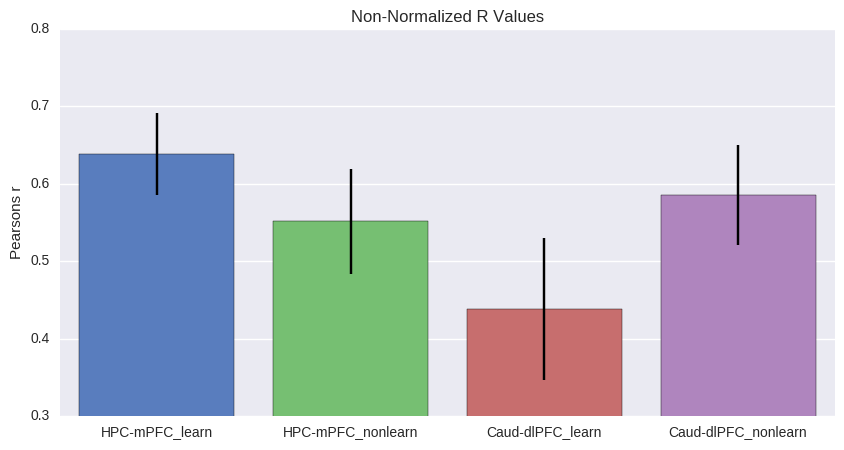

In [49]:
from math import sqrt
%matplotlib inline
import seaborn as sns
sns.set_palette('muted')
import matplotlib.pyplot as plt

N = 4
conditions = ['HPC-mPFC_learn', 'HPC-mPFC_nonlearn', 'Caud-dlPFC_learn', 'Caud-dlPFC_nonlearn']
means_allsubjs = [np.average(correlation_chart['1_HPC-mPFC_learning']),
                  np.average(correlation_chart['2_HPC-mPFC_nonlearning']),
                  np.average(correlation_chart['3_Caudate-dlPFC_learning']),
                  np.average(correlation_chart['4_Caudate-dlPFC_nonlearning'])]
sem_allsubjs = [stats.sem(correlation_chart['1_HPC-mPFC_learning']),
                stats.sem(correlation_chart['2_HPC-mPFC_nonlearning']),
                stats.sem(correlation_chart['3_Caudate-dlPFC_learning']),
                stats.sem(correlation_chart['4_Caudate-dlPFC_nonlearning'])]

cohens_d = ((np.average(correlation_chart['1_HPC-mPFC_learning']) - np.average(correlation_chart['2_HPC-mPFC_nonlearning'])) 
            / (sqrt((np.std(correlation_chart['1_HPC-mPFC_learning'], ddof = 1)) 
            ** 2 + np.std(correlation_chart['2_HPC-mPFC_nonlearning'], ddof = 1) ** 2) / 2))

print np.average(correlation_chart['1_HPC-mPFC_learning'])
print np.average(correlation_chart['2_HPC-mPFC_nonlearning'])

print ""
print 'T-test: HPC-mPFC_learning vs. HPC-mPFC_nonlearning'
print stats.ttest_rel(correlation_chart['1_HPC-mPFC_learning'], correlation_chart['2_HPC-mPFC_nonlearning'])
print "Cohen's d =", cohens_d
print ""

print 'T-test: Caudate-dlPFC_learning vs. Caudate-dlPFC_nonlearning'
print stats.ttest_rel(correlation_chart['3_Caudate-dlPFC_learning'], correlation_chart['4_Caudate-dlPFC_nonlearning'])
print ""



ind = np.arange(N)
width = 0.5

fig, ax = plt.subplots(figsize=(10,5))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax = sns.barplot(ind, means_allsubjs, yerr = sem_allsubjs, ecolor = 'black')

ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.set_ylim(0.3,0.8)
ax.set_ylabel("Pearsons r")
#ax.set_xlabel("Regional Correlations")
ax.set_title("Non-Normalized R Values")
#plt.savefig("/home/data/madlab/scripts/wmaze/anal_MR_thesis/fixed_before_conditional/model3/model3_B_bar.jpg")
plt.show()

0.638340007514
0.551386693865

T-test: HPC-mPFC_learning vs. HPC-mPFC_nonlearning
Ttest_relResult(statistic=1.1391037181719228, pvalue=0.26881846329538739)
Cohen's d = 0.45304333855


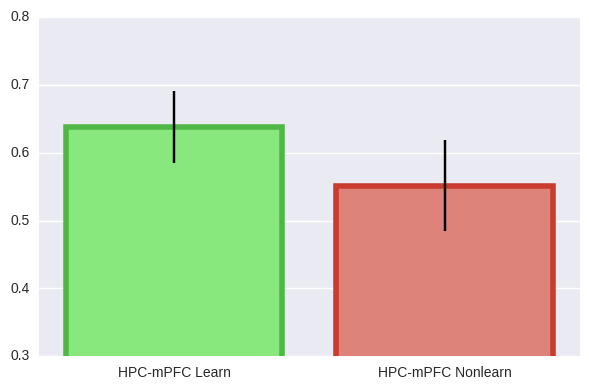

In [50]:
from math import sqrt
%matplotlib inline
import seaborn as sns
sns.set_palette('muted')
import matplotlib.pyplot as plt

N = 2
conditions = ['HPC-mPFC Learn', 'HPC-mPFC Nonlearn']

means_allsubjs = [np.average(correlation_chart['1_HPC-mPFC_learning']),
                  np.average(correlation_chart['2_HPC-mPFC_nonlearning'])]
sem_allsubjs = [stats.sem(correlation_chart['1_HPC-mPFC_learning']),
                stats.sem(correlation_chart['2_HPC-mPFC_nonlearning'])]

cohens_d = ((np.average(correlation_chart['1_HPC-mPFC_learning']) - np.average(correlation_chart['2_HPC-mPFC_nonlearning'])) 
            / (sqrt((np.std(correlation_chart['1_HPC-mPFC_learning'], ddof = 1)) 
            ** 2 + np.std(correlation_chart['2_HPC-mPFC_nonlearning'], ddof = 1) ** 2) / 2))

print np.average(correlation_chart['1_HPC-mPFC_learning'])
print np.average(correlation_chart['2_HPC-mPFC_nonlearning'])

print ""
print 'T-test: HPC-mPFC_learning vs. HPC-mPFC_nonlearning'
print stats.ttest_rel(correlation_chart['1_HPC-mPFC_learning'], correlation_chart['2_HPC-mPFC_nonlearning'])
print "Cohen's d =", cohens_d

fig, ax = plt.subplots()
pal = ["#4fb745", "#c93b2e"] #outline  for bars
pal = sns.color_palette(pal)
pal2 = ["#79f96d", "#ed756a"] #color-fill for bars
pal2 = sns.color_palette(pal2)
ind = np.arange(N)   
sns.barplot(ind, means_allsubjs, yerr = sem_allsubjs, palette = pal2, 
            ecolor = 'black', edgecolor = pal, linewidth = 4)
ax.set_xticklabels(conditions)
ax.set_ylabel('')
ax.set_ylim(0.3, 0.8)
plt.tight_layout()
plt.savefig("/home/data/madlab/scripts/wmaze/anal_MR_thesis/fixed_before_conditional/model3/linegraph.jpg")
plt.show()

T-test: Caudate-dlPFC_learning vs. Caudate-dlPFC_nonlearning
Ttest_relResult(statistic=-0.37815252911009967, pvalue=0.70999772193921706)



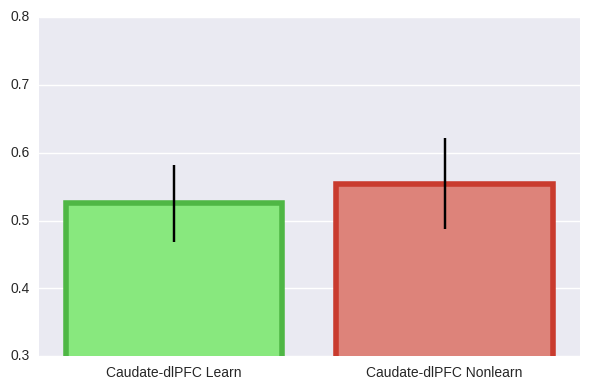

In [25]:
N = 2
conditions = ['Caudate-dlPFC Learn', 'Caudate-dlPFC Nonlearn']

means_allsubjs = [np.average(correlation_chart['3_Caudate-dlPFC_learning']),
                  np.average(correlation_chart['4_Caudate-dlPFC_nonlearning'])]
sem_allsubjs = [stats.sem(correlation_chart['3_Caudate-dlPFC_learning']),
                stats.sem(correlation_chart['4_Caudate-dlPFC_nonlearning'])]


print 'T-test: Caudate-dlPFC_learning vs. Caudate-dlPFC_nonlearning'
print stats.ttest_rel(correlation_chart['3_Caudate-dlPFC_learning'], correlation_chart['4_Caudate-dlPFC_nonlearning'])
print ""


fig, ax = plt.subplots()
pal = ["#4fb745", "#c93b2e"] #outline  for bars
pal = sns.color_palette(pal)
pal2 = ["#79f96d", "#ed756a"] #color-fill for bars 
pal2 = sns.color_palette(pal2)
ind = np.arange(N)   
sns.barplot(ind, means_allsubjs, yerr = sem_allsubjs, palette = pal2, 
            ecolor = 'black', edgecolor = pal, linewidth = 4)
ax.set_xticklabels(conditions)
ax.set_ylabel('')
ax.set_ylim(0.3, 0.8)
plt.tight_layout()
plt.savefig("/home/data/madlab/scripts/wmaze/anal_MR_thesis/fixed_before_conditional/model3/linegraph.jpg")
plt.show()

In [26]:
print np.average(correlation_chart['1_HPC-mPFC_learning'])
print np.average(correlation_chart['2_HPC-mPFC_nonlearning'])
print np.average(correlation_chart['3_Caudate-dlPFC_learning'])
print np.average(correlation_chart['4_Caudate-dlPFC_nonlearning'])
print ""
print np.std(correlation_chart['1_HPC-mPFC_learning'])
print np.std(correlation_chart['2_HPC-mPFC_nonlearning'])
print np.std(correlation_chart['3_Caudate-dlPFC_learning'])
print np.std(correlation_chart['4_Caudate-dlPFC_nonlearning'])

print 'HPC-mPFC Learning', stats.normaltest(correlation_chart['1_HPC-mPFC_learning'])[:]
print 'HPC-mPFC Nonlearning', stats.normaltest(correlation_chart['2_HPC-mPFC_nonlearning'])[:]
print ""
print 'Caudate-dlPFC Learning', stats.normaltest(correlation_chart['3_Caudate-dlPFC_learning'])[:]
print 'Caudate-dlPFC Nonlearning', stats.normaltest(correlation_chart['4_Caudate-dlPFC_nonlearning'])[:]

0.617501065963
0.519637386832
0.525053627789
0.553927730821

0.2267718801
0.288744086248
0.234242046615
0.276072642753
HPC-mPFC Learning (6.2349172476903814, 0.044269531112036693)
HPC-mPFC Nonlearning (5.2832344708885888, 0.071245954852556082)

Caudate-dlPFC Learning (8.986630681913919, 0.011183505147285234)
Caudate-dlPFC Nonlearning (5.0719443063856291, 0.079184702173551558)


## Normalized correlation matrix for beta series

In [27]:
# Use Numpy's arctangent function to normalize correlations
norm_corr = np.arctanh(corr_matrix[:, 1:])
#print(norm_nonlearning)

In [28]:
import pandas as pd
norm_chart = {}
norm_chart['1_HPC-mPFC_learning'] = norm_corr[:, 0]
norm_chart['2_HPC-mPFC_nonlearning'] = norm_corr[:, 1] 
norm_chart['3_Caudate-dlPFC_learning'] = norm_corr[:, 2]
norm_chart['4_Caudate-dlPFC_nonlearning'] = norm_corr[:, 3]
norm_chart_df = pd.DataFrame.from_dict(norm_chart)

In [29]:
norm_chart_df

,1_HPC-mPFC_learning,2_HPC-mPFC_nonlearning,3_Caudate-dlPFC_learning,4_Caudate-dlPFC_nonlearning
0,0.457154,0.595444,0.407844,0.406638
1,0.754938,0.998288,0.582974,0.959955
2,0.880919,0.541306,0.746907,0.636869
3,0.962570,0.440257,0.539245,0.508285
4,1.158958,1.165875,1.064062,1.280347
5,1.100906,0.695556,0.202610,0.378150
6,0.544433,0.667771,0.685919,0.546978
7,0.849603,-0.177693,0.477025,-0.011383
8,0.928743,1.097102,1.072544,0.911936
9,0.621208,0.625583,0.620196,1.046201


### Descriptive Statistics

In [30]:
print "Mean: HPC-mPFC_learning"
print np.average(norm_corr[:, 0])
print "SD: HPC-mPFC_learning"
print stats.sem(norm_corr[:, 0])
print ""
print "Mean: HPC-mPFC_nonlearning"
print np.average(norm_corr[:, 1])
print "SD: HPC-mPFC_nonlearning"
print stats.sem(norm_corr[:, 1])
print ""
print "Mean: Caudate-dlPFC_learning"
print np.average(norm_corr[:, 2])
print "SD: Caudate-dlPFC_learning"
print stats.sem(norm_corr[:, 2])
print ""
print "Mean: Caudate-dlPFC_nonlearning"
print np.average(norm_corr[:, 3])
print "SD: Caudate-dlPFC_nonlearning"
print stats.sem(norm_corr[:, 3])

Mean: HPC-mPFC_learning
0.807570047962
SD: HPC-mPFC_learning
0.0951250347851

Mean: HPC-mPFC_nonlearning
0.651918647448
SD: HPC-mPFC_nonlearning
0.0974661789168

Mean: Caudate-dlPFC_learning
0.63304895966
SD: Caudate-dlPFC_learning
0.0780339255567

Mean: Caudate-dlPFC_nonlearning
0.72247732163
SD: Caudate-dlPFC_nonlearning
0.107556754491


### Inferential Statistics

In [31]:
print 'T-test: HPC-mPFC_learning vs. HPC-mPFC_nonlearning'
print stats.ttest_rel(norm_corr[:, 0], norm_corr[:, 1])
print ""

print 'T-test: Caudate-dlPFC_learning vs. Caudate-dlPFC_nonlearning'
print stats.ttest_rel(norm_corr[:, 2], norm_corr[:, 3])
print ""

print "Bonferroni correction"
print '0.05/2 = 0.025'

T-test: HPC-mPFC_learning vs. HPC-mPFC_nonlearning
Ttest_relResult(statistic=1.3433849705122078, pvalue=0.19680672240923275)

T-test: Caudate-dlPFC_learning vs. Caudate-dlPFC_nonlearning
Ttest_relResult(statistic=-0.85622430440760922, pvalue=0.40378160560383525)

Bonferroni correction
0.05/2 = 0.025


In [1]:
# Scatterplot

ax = []
for a in range(0,64,1):
    ax.append(a)

x = ax
print len(y)

#print len(x)
y = all_data['hp_learning']
z = all_data['mPFC_learning']
#print len(y)
#print len(z)


fig, (ax, ax2) = plt.subplots(ncols = 2, figsize=(11, 4), sharex = True, sharey = True)
#fit = np.polyfit(x, y, deg = 1)
ax.plot(x, y, color = 'blue')
#ax.scatter(x, y, c = 'blue', alpha = 0.5)
ax.set_ylabel('Activation')
ax.set_xlabel('Trials')
ax.set_title('HPC Activation Across Learning Trials')


#fit2 = np.polyfit(x, z, deg = 1)
ax2.plot(x, z, color = 'purple')
#ax2.scatter(x, z, c = 'purple', alpha = 0.5)
ax2.set_ylabel('Activation')
ax2.set_xlabel('Trials')
ax2.set_title('mPFC Activation Across Learning Trials')


NameError: name 'y' is not defined